### Load packages and read tables.

In [2]:
%run /Users/J.Kim54@lse.ac.uk/pubg_analysis

In [3]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read a table that contains telemetry data.
td = spark.read.parquet("/tmp/dt_for_cheater_analysis.parquet")
td.registerTempTable("td")

# Read a table that contains player data.
players = spark.sql("SELECT * FROM td_nodes")
players.registerTempTable("players")

# Get cheaters who were banned between March 1 and March 3.
# The assumption is that cheaters who were banned during the period above always did cheat.
cheaters = spark.sql("SELECT * FROM td_nodes WHERE ban_date <= '2019-03-03'")
cheaters.registerTempTable("cheaters")

### Calculate the average kill ratio for each cheater.

In [5]:
# Get a dataframe that stores kill records of cheaters.
c_kill_logs = spark.sql("SELECT mid, src, time, m_date, ban_date FROM td t JOIN cheaters c ON t.src = c.id")
c_kill_logs.registerTempTable("kill_logs")

# Get a dataframe that stores death records of cheaters.
c_death_logs = spark.sql("SELECT mid, dst, time, m_date, ban_date FROM td t JOIN cheaters c ON t.dst = c.id")
c_death_logs.registerTempTable("death_logs")

avg_kill_ratio_by_date, overall_avg_kill_ratio = cal_avg_kill_ratio(c_kill_logs, c_death_logs)

# Plot the distribution of average kill ratio.
fig = overall_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', edgecolor='red', bins=40, 
                                  weights=np.zeros_like(overall_avg_kill_ratio['avg_kill_ratio'])+1./len(overall_avg_kill_ratio['avg_kill_ratio']))
plt.xlabel("Average kill ratio")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

# Calculate the mean and median of average kill ratio.
print(overall_avg_kill_ratio['avg_kill_ratio'].mean())
print(overall_avg_kill_ratio['avg_kill_ratio'].median())

# Count the number of unique cheaters who have the information on the averge kill ratio.
# print(len(overall_avg_kill_ratio['avg_kill_ratio']))

0.766097299293
0.8235294117647058

### Calculate the average kill ratio for each non-cheater.

In [7]:
# Create a dataframe that stores kill records of non-cheaters.
nc_kill_logs = spark.sql("SELECT mid, src, dst, time, m_date FROM td t JOIN players p ON t.src = p.id WHERE cheating_flag = '0'")
nc_kill_logs.registerTempTable("kill_logs")

# Create a dataframe that stores death counts of non-cheaters.
nc_death_logs = spark.sql("SELECT mid, src, dst, time, m_date FROM td t JOIN players p ON t.dst = p.id WHERE cheating_flag = '0'")
nc_death_logs.registerTempTable("death_logs")

nc_avg_kill_ratio_by_date, nc_overall_avg_kill_ratio = cal_avg_kill_ratio_by_date(nc_kill_logs, nc_death_logs)

# Plot the distribution of average kill ratio.
fig = nc_overall_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', edgecolor='blue', bins=40, 
                                     weights=np.zeros_like(nc_overall_avg_kill_ratio['avg_kill_ratio'])+1./len(nc_overall_avg_kill_ratio['avg_kill_ratio']))
plt.xlabel("Average kill ratio")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

# Calculate the mean and median of average kill ratio.
print(nc_overall_avg_kill_ratio['avg_kill_ratio'].mean())
print(nc_overall_avg_kill_ratio['avg_kill_ratio'].median())

# Count the number of unique non-cheaters who have the information on the averge kill ratio.
# print(len(nc_overall_avg_kill_ratio['avg_kill_ratio']))

0.404507873555
0.4436873145399354

### Plot the histogram of average kill ratio for both cheaters and non-cheaters.

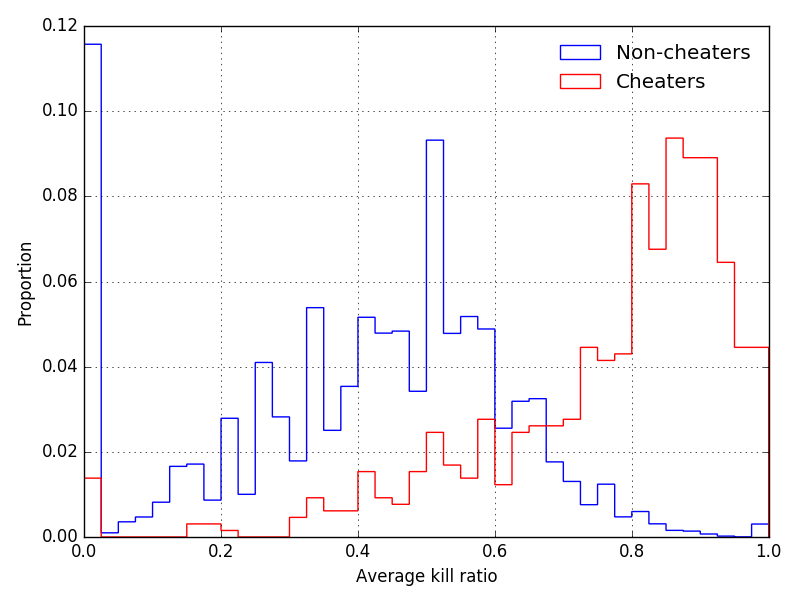

In [9]:
# Plot the histograms of cheaters and non-cheaters together.
ax = nc_overall_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', weights=np.zeros_like(nc_overall_avg_kill_ratio['avg_kill_ratio'])+1./len(nc_overall_avg_kill_ratio['avg_kill_ratio']), 
                                    edgecolor='blue', bins=40, label='Non-cheaters')
fig = overall_avg_kill_ratio.hist(column='avg_kill_ratio', histtype='step', weights=np.zeros_like(overall_avg_kill_ratio['avg_kill_ratio'])+1./len(overall_avg_kill_ratio['avg_kill_ratio']), 
                                  edgecolor='red', bins=40, label='Cheaters', ax=ax)
plt.title('')
plt.xlabel('Average kill ratio')
plt.ylabel('Proportion')
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
image = plt.show() 
display(image)

### Calculate the average time difference between consecutive kills for each cheater.

In [11]:
# Get a dataframe that stores kill records of cheaters.
c_kill_logs.registerTempTable("kill_logs")
c_avg_kill_interval_by_date, c_overall_avg_kill_interval = cal_avg_time_diff_between_kills_of_cheaters(c_kill_logs)

# Plot the distribution of the overall average time difference between kills.
fig = c_overall_avg_kill_interval.hist(column='delta', weights=np.zeros_like(c_overall_avg_kill_interval['delta'])+1./len(c_overall_avg_kill_interval['delta']), 
                                       histtype='step', edgecolor='red', bins=40)
plt.xlabel("Average time difference between kills")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

# Calculate the mean and median of average time difference between kills.
print(c_overall_avg_kill_interval['delta'].mean())
print(c_overall_avg_kill_interval['delta'].median())

# Count the number of unique cheaters who have the information on the averge time difference between kills.
# print(len(c_overall_avg_kill_interval['delta']))

140.183049722
123.47688505747126

### Calculate the average time difference between consecutive kills for each non-cheater.

In [13]:
# Get a dataframe that stores kill records of non-cheaters.
nc_kill_logs.registerTempTable("kill_logs")

# The average time difference between kills for non-cheaters is calculated by using a different function due to the performance issue.
nc_overall_avg_kill_interval = cal_avg_time_diff_between_kills_of_non_cheaters(nc_kill_logs)

fig = nc_overall_avg_kill_interval.hist(column='delta', weights=np.zeros_like(nc_overall_avg_kill_interval['delta'])+1./len(nc_overall_avg_kill_interval['delta']), 
                                        histtype='step', edgecolor='blue', bins=40)
plt.xlabel("Average time difference between kills")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

# Calculate the mean and median of average time difference between kills.
print(nc_overall_avg_kill_interval['delta'].mean())
print(nc_overall_avg_kill_interval['delta'].median())

# Count the number of unique non-cheaters who have the information on the averge time difference between kills.
# print(len(nc_overall_avg_kill_interval['delta']))

194.108762718
172.63484848484848

### Plot the histogram of average time difference between kills for both cheaters and non-cheaters.

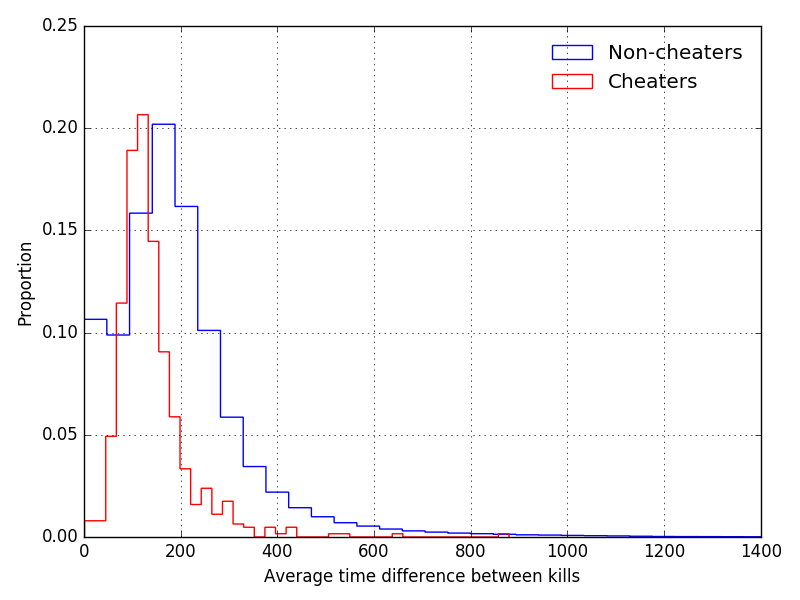

In [15]:
# Plot the histograms of cheaters and non-cheaters together.
ax = nc_overall_avg_kill_interval.hist(column='delta', histtype='step', weights=np.zeros_like(nc_overall_avg_kill_interval['delta'])+1./len(nc_overall_avg_kill_interval['delta']), 
                                       edgecolor='blue', bins=40, label='Non-cheaters')
fig = c_overall_avg_kill_interval.hist(column='delta', histtype='step', weights=np.zeros_like(c_overall_avg_kill_interval['delta'])+1./len(c_overall_avg_kill_interval['delta']), 
                                       edgecolor='red', bins=40, label='Cheaters', ax=ax)
plt.title('')
plt.xlabel('Average time difference between kills')
plt.ylabel('Proportion')
plt.xlim(xmax=1400) # Exclude outliers.
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
image = plt.show() 
display(image)

### Perform a t-test.

In [17]:
import scipy
import scipy.stats
from scipy.stats import ttest_ind

# Get the results of t-tests.
print(scipy.stats.ttest_ind(overall_avg_kill_ratio['avg_kill_ratio'], nc_overall_avg_kill_ratio['avg_kill_ratio'], equal_var=False))
print(scipy.stats.ttest_ind(c_overall_avg_kill_interval['delta'], nc_overall_avg_kill_interval['delta'], equal_var=False))

Ttest_indResult(statistic=48.642923394359187, pvalue=5.2118233031161431e-219)
Ttest_indResult(statistic=-17.804942012731505, pvalue=8.6443381495780399e-58)

### References
* https://towardsdatascience.com/a-brief-introduction-to-pyspark-ff4284701873
* https://changhsinlee.com/pyspark-udf/
* https://stackoverflow.com/questions/40804265/how-to-calculate-time-difference-by-group-using-pandas